# Joyce Mai -- AI Skills Showcase

Hi! My name is Joyce, and I'm a 2B Computer Engineering student. I first became interested in ML/AI through exploring the math behind powerful models, but as an engineer, I'm especially drawn to applying these technologies to real-world challenges. I'm excited about contributing to See-DR to gain experience working with real-world, messy data, building reliable software systems to support the model, and contributing to health care system.

# 🐱🐶 Cat vs Dog Classification with CNN (CIFAR-10)
This notebook demonstrates a simple CNN model built with PyTorch to classify cats and dogs from the CIFAR-10 dataset.
The CNN model has two convolutional layers and two linear layers, achieving 74.10% accuracy with 25 epochs.

**Note**: For best performance, it is recommended to run this notebook in Google Colab with GPU enabled.

In [ ]:
pip install torch torchvision matplotlib

In [ ]:
#import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

#load dataset CIFAR10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_data = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [ ]:
#data preprocessing
#extract cat and dog classes
cat_dog_labels = [3,5]
train_idx = [i for i, (_, label) in enumerate(train_data) if label in cat_dog_labels]
test_idx = [i for i, (_, label) in enumerate(test_data) if label in cat_dog_labels]

train_set = Subset(train_data, train_idx)
test_set = Subset(test_data, test_idx)

#update labels to binary (cat=0, dog=1)
class ToBinary(torch.utils.data.Dataset):
    def __init__(self, subset):
        self.subset = subset
    def __getitem__(self, index):
        x, y = self.subset[index]
        return x, 0 if y == 3 else 1
    def __len__(self):
        return len(self.subset)

train_set_bi = ToBinary(train_set)
test_set_bi = ToBinary(test_set)

trainloader = DataLoader(train_set_bi, batch_size=64)
testloader = DataLoader(test_set_bi, batch_size=64)

In [ ]:
#CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #input size: [batch_size, 3(RGB channels), 32(height), 32(width)]
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) #takes 3-channel RGB input, applies 16 filters, each of size 3×3
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)#hidden layer
        self.fc2 = nn.Linear(128, 2)#output layer
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        #[batch_size, 16, 16, 16]
        x = self.pool(nn.functional.relu(self.conv2(x)))
        #[batch_size, 32, 8, 8]
        x = x.view(-1, 32 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Device setup (CUDA preferred)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)


In [ ]:
#model training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 25
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() #zero out the gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.3f}")

print("Training done.")

In [19]:
#evaluation
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

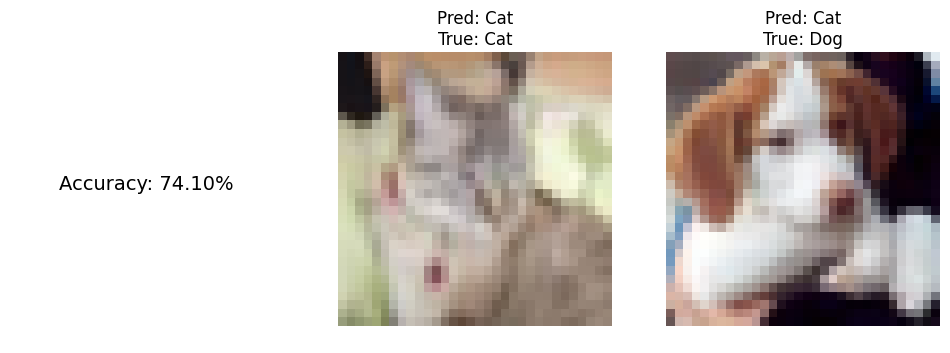

In [20]:
#visualization
#get a batch of test images for visualization
dataiter = iter(testloader)
images, labels = next(dataiter)

#get predictions
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

#unnormalize images for visualization
images = images / 2 + 0.5 # unnormalize
npimg = images.numpy()

#choose two images to visualize
idx1, idx2 = 1, 3

_, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].axis('off')
axes[0].text(0.5, 0.5, f"Accuracy: {accuracy:.2f}%", fontsize=14, ha='center')

for ax, idx in zip(axes[1:], [idx1, idx2]):
    ax.imshow(np.transpose(npimg[idx], (1, 2, 0)))
    ax.set_title(f"Pred: {'Dog' if preds[idx]==1 else 'Cat'}\nTrue: {'Dog' if labels[idx]==1 else 'Cat'}")
    ax.axis('off')

plt.show()